# 13. Portfolio Optimization with Reinforcement Learning

This tutorial provides a step-by-step guide for implementing a Unit Operator with a Portfolio Strategy in the ASSUME framework. By the end of this guide, you will be familiar with the process of creating and integrating a Portfolio within the electricity market simulation environment provided by ASSUME.


**We will cover the following topics:**

#TODO: rewrite the inhaltverzeichnis
1. [Introduction to Unit Operators and Portfolio Strategy](#1.-introduction-to-unit-operators-and-portfolio-strategy)
2. [Setting up the ASSUME framework](#2.-setting-up-assume)
3. [Developing a forecast](#3.-developing-a-new-forecast)
4. [Formulating a portfolio strategy](#4.-formulating-a-portfolio-strategy)
5. [Comparing scenarios in ASSUME](#5.-comparing-scenarios-in-assume)

## 1. Introduction to Unit Operators and Portfolio Strategy

The ASSUME framework is a versatile tool for simulating electricity markets, allowing researchers and industry professionals to analyze market dynamics and strategies.

A **UnitsOperator** in ASSUME refers to a market role that submits buy or sell bids in the market for multiple units in its portfolio, according to the bidding strategy of each unit. Unit operators can themselves have a portfolio strategy, that is a **UnitOperatorStrategy**, which aims at optimizing the joint market returns from the bids of all units of the operator. 

In this tutorial, we will create a portfolio strategy for a unit operator with multiple units.

## Why portfolio optimization 

#TODO Explanation

#TODO Picture


In [ ]:
# this cell is used to display the image in the notebook when using colab
# or running the notebook locally

import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG

image_path = "assume-repo/docs/source/img/new_picture.svg"
alt_image_path = "../../docs/source/img/new_picture.svg"

# Try to display SVG using different methods
if os.path.exists(image_path):
    display(SVG(image_path))
elif os.path.exists(alt_image_path):
    display(SVG(alt_image_path))
else:
    print("Image file not found. Please check the path.")


#TODO: rewrite picture description 

## 2. Setting Up ASSUME

Before we create our custom unit, let's set up the ASSUME framework. We'll install the ASSUME core package and clone the repository containing predefined scenarios.

**You don't need to execute the following code cells if you already have the ASSUME framework installed and/or the repository cloned.**

In [ ]:
import importlib.util

# Check if 'google.colab' is available
IN_COLAB = importlib.util.find_spec("google.colab") is not None
if IN_COLAB:
    !pip install assume-framework

In [ ]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

Note that Google Colab does not support Docker functionalities, so features dependent on Docker will not be available here.

**Select input files path**

We also need to differentiate between the input file paths when using this tutorial in Google Colab and a local environment. The code snippets will include both options for your convenience.

In [ ]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

## 3. Portfolio Reinforcement Learning Strategy

Now, we'll define a rule-based portfolio strategy for a Units Operator. Portfolio strategies optimize the entire portfolio of the operator (i.e., its set of units). 
By default, units operators without a portfolio strategy receive a `DirectUnitOperatorStrategy`, which calculates the bids of each unit according to their bidding strategy and include additional information, such as `bid_id` and `unit_id`.

**Key features of a Portfolio Strategy**
1. **Overrides unit bidding strategies**: the portfolio strategies of an operator is called before the bidding strategies of individual units and can override them.
2. **Transforms a portfolio strategy into unit bids**: The portfolio-level strategy is translated into bids that are assigned to the units in the portfolio. This ensures that the market clearing can be used to determine the dispatch of the units. 
3. **Calculates operator reward**: Rewards are computed at a portfolio-level, if needed.

**PivotalityStrategy**

This strategy will use market information on the demand forecast to place bids at a higher price if the operator expects to be pivotal. Whenever the RSI, computed using the demand forecast and the residual supply forecast, is lower than a threshold (`residual_supply_index`), the UnitsOperator will strategically bid the unit with the highest marginal cost at a higher price (`pivotal_price`).

In [ ]:
#TODO: copy code of portfolio RL strategy


## 4. Comparing simulations

**Multi-agent RL units**

In [ ]:
#TODO: remove sys.path.append (last step)
import os, sys
sys.path.append(os.path.abspath("../../"))
from assume import World
from assume.scenario.loader_csv import load_scenario_folder, run_learning
import numpy as np
%load_ext autoreload
%autoreload 2

os.makedirs("local_db", exist_ok=True)
inputs_path = "../inputs"
example = "02b"
db_uri = f"sqlite:///../local_db/assume_{example}.db"

pp_world = World(database_uri=db_uri, export_csv_path=f"outputs/13_rl_portfolio")
load_scenario_folder(
    pp_world,
    inputs_path=inputs_path,
    scenario=f"example_{example}",
    study_case=False,
)

np.random.seed(42)  # Set a random seed for reproducibility


# Run the training phase
if pp_world.learning_config.get("learning_mode", False):
    run_learning(pp_world)

# Execute final evaluation run (no exploration)
pp_world.run()


**Single-agent RL operator**

In [ ]:

example = "02f"
db_uri = f"sqlite:///../local_db/assume_{example}.db"

op_world = World(database_uri=db_uri, export_csv_path=f"outputs/13_rl_portfolio")
load_scenario_folder(
    op_world,
    inputs_path=inputs_path,
    scenario=f"example_{example}",
    study_case=False,
)

np.random.seed(42)  # Set a random seed for reproducibility

# Manually add outputs and forecaster for Operator-RL (before learning)
rl_op = op_world.unit_operators["Operator-RL"]
rl_op.init_portfolio_learning()

if op_world.learning_config.get("learning_mode", False):
    # During learning, outputs and forecaster are added in write_to_learning_mode
    run_learning(op_world)

# Manually add outputs and forecaster for Operator-RL (after learning)
rl_op.init_portfolio_learning()
# Execute final evaluation run (no exploration)
op_world.run()



## 5. Evaluating scenarios

After running both simulations, we can now compare them through loading the SQL databases and plotting the results.

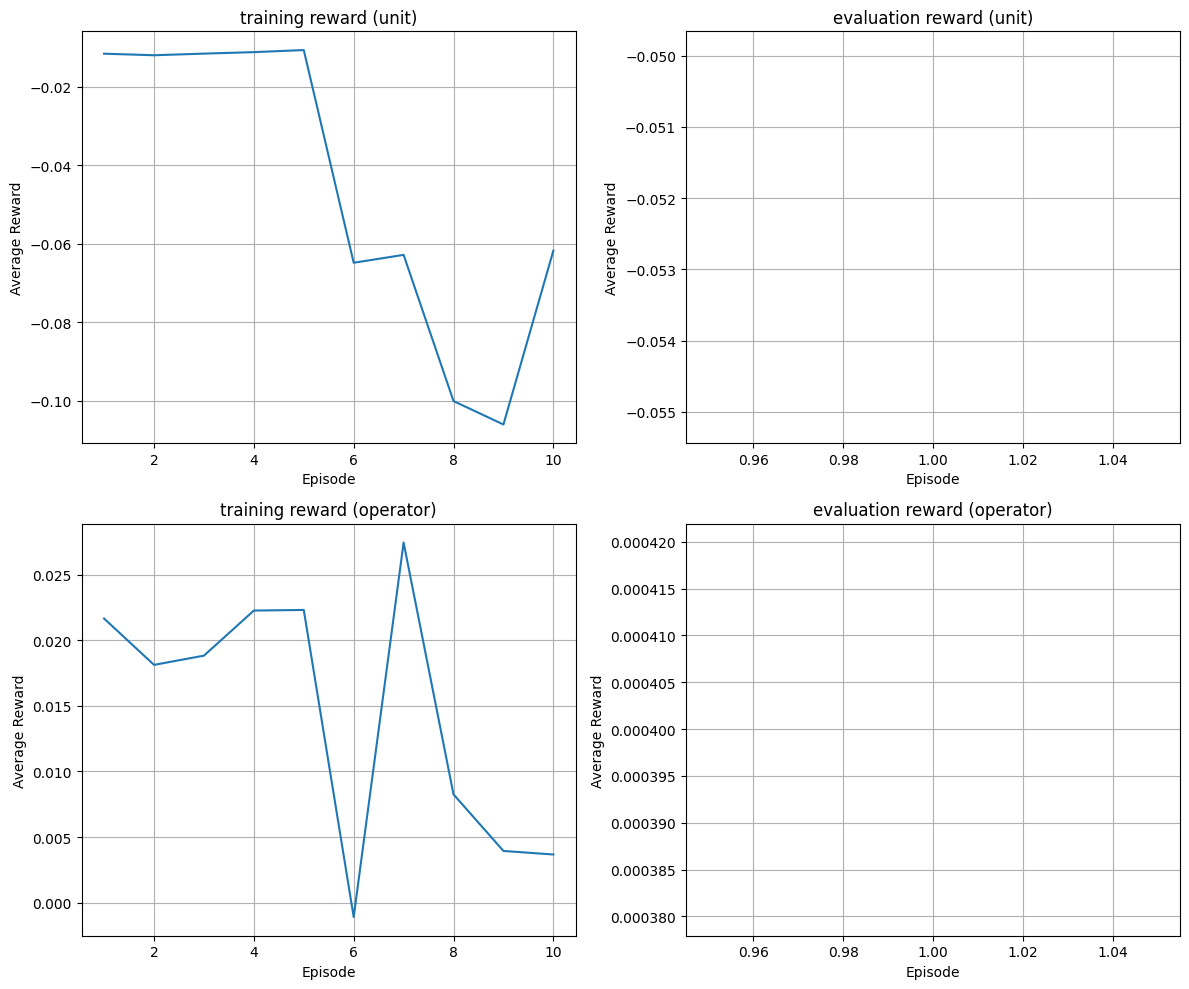

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt



def read_sql(example): 
  # Connect to the simulation database
    engine = create_engine(f"sqlite:///../local_db/assume_{example}.db")

    # Query rewards for specific simulation and unit
    sql = f"""
            SELECT
                datetime,
                bidder,
                reward,
                simulation,
                evaluation_mode,
                episode
            FROM rl_params
            WHERE simulation = 'example_{example}_base'
            ORDER BY datetime
            """
    reward_df = pd.read_sql(sql, engine)
    reward_df.rename(columns={"evaluation_mode": "eval"}, inplace=True)
    return reward_df

# Load query results
reward_dfs =  {
      "unit": read_sql('02b'),
      "operator": read_sql('02f'),
      }


# --- Separate plots for training and evaluation ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10),tight_layout=True)
colors = ["tab:blue", "tab:orange"]

for i, bidder in enumerate(reward_dfs):
  for j, mode in enumerate(["training", "evaluation"]):
      
    plot_df = reward_dfs[bidder]
    plot_df = plot_df[plot_df["eval"] == j]
    plot_grouped = plot_df.groupby("episode")["reward"].mean()

    axes[i,j].plot(plot_grouped.index, plot_grouped.values, color=colors[j])
    axes[i,j].set_title(f"{mode} reward ({bidder})")
    axes[i,j].set_ylabel("Average Reward")
    axes[i,j].set_xlabel("Episode")
    axes[i,j].grid(True)


This concludes our tutorial. By following these steps, you have successfully created a Portfolio Strategy for a UnitsOperator and integrated it into the ASSUME framework.